<a href="https://colab.research.google.com/github/HikariJadeEmpire/AudioBook_DATAEngineering/blob/main/S02_DATACleansing_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# In this file, I will :

Clean the data using PySpark, follow the steps below:
- Data profiling
- EDA
- Anomaly Detection with PySpark
- Export

First, we will prepare the necessary tools.

In [ ]:
!apt-get update                                                                           # Update all Package in this VM
!apt-get install openjdk-8-jdk-headless -qq > /dev/null                                   # install Java Development Kit (Spark requires this)
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz  # install Spark 3.1.2
!tar xzvf spark-3.1.2-bin-hadoop2.7.tgz                                                   # Unzip Spark 3.1.2
!pip install -q findspark==1.3.0                                                          # To connect with Spark, install the required Python package.

In [ ]:
# To make Python recognize Spark, set the environment variable.
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
! ls

drive  sample_data  spark-3.1.2-bin-hadoop2.7  spark-3.1.2-bin-hadoop2.7.tgz


In [ ]:
# Install PySpark to Python

!pip install pyspark==3.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880756 sha256=63c19f6263d068c7020d5b7748663065bdefcc68ce53044a533c02293e9200be
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
# Check the Google Colab server's core. (cpu cores)

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.156
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.31
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
# Create Spark Session

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

To perform a multi-core operation and utilize all available CPU cores using Spark, we use ```local[*]```

In [ ]:
import sys

print(f'Python version : {sys.version}\nSpark version : {spark.version}')

Python version : 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Spark version : 3.1.2


# DATA Profiling

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/myColab_Notebooks/myData.csv', header = True, inferSchema = True, )

## Tips
To convert Pandas dataframe to Spark dataframe :

```
sparkDF = spark.createDataFrame(pandasDF)

```

In [ ]:
df.show()

+-------------------+--------+--------+--------------------+--------+--------------------+--------------------+------------------+-------------------+------------------+--------------------+--------------------+------+--------------------+-----+---------------+------------------+
|          timestamp| user_id|book_id2|             country|Book_ID4|          Book Title|       Book Subtitle|       Book Author|      Book Narrator|     Audio Runtime|      Audiobook_Type|          Categories|Rating|Total No. of Ratings|Price|conversion_rate|         THB_Price|
+-------------------+--------+--------+--------------------+--------+--------------------+--------------------+------------------+-------------------+------------------+--------------------+--------------------+------+--------------------+-----+---------------+------------------+
|2021-05-01 00:00:01|ad8eca41|    1584|            Portugal|    1584|        Sycamore Row|                null|      John Grisham|       Michael Beck|20 hrs 

In [ ]:
df.dtypes

[('timestamp', 'string'),
 ('user_id', 'string'),
 ('book_id2', 'int'),
 ('country', 'string'),
 ('Book_ID4', 'int'),
 ('Book Title', 'string'),
 ('Book Subtitle', 'string'),
 ('Book Author', 'string'),
 ('Book Narrator', 'string'),
 ('Audio Runtime', 'string'),
 ('Audiobook_Type', 'string'),
 ('Categories', 'string'),
 ('Rating', 'string'),
 ('Total No. of Ratings', 'double'),
 ('Price', 'double'),
 ('conversion_rate', 'double'),
 ('THB_Price', 'double')]

In [ ]:
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id2: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- Book_ID4: integer (nullable = true)
 |-- Book Title: string (nullable = true)
 |-- Book Subtitle: string (nullable = true)
 |-- Book Author: string (nullable = true)
 |-- Book Narrator: string (nullable = true)
 |-- Audio Runtime: string (nullable = true)
 |-- Audiobook_Type: string (nullable = true)
 |-- Categories: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Total No. of Ratings: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- conversion_rate: double (nullable = true)
 |-- THB_Price: double (nullable = true)



In [ ]:
# Count Row & column
print( (df.count(), len(df.columns)) )

(1998821, 17)


In [ ]:
df.describe().show()

+-------+-------------------+--------+-----------------+-------+-----------------+-------------------------------------+--------------------+-------------+--------------------+--------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+
|summary|          timestamp| user_id|         book_id2|country|         Book_ID4|                           Book Title|       Book Subtitle|  Book Author|       Book Narrator| Audio Runtime|      Audiobook_Type|          Categories|             Rating|Total No. of Ratings|             Price|   conversion_rate|         THB_Price|
+-------+-------------------+--------+-----------------+-------+-----------------+-------------------------------------+--------------------+-------------+--------------------+--------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+
|  c

## Select columns

In [ ]:
from pyspark.sql import functions as F

# F command is funtions in SQL
# in SQL : SELECT column_name1 AS new_column_name, column_name2 FROM df

df = df.select( F.col("timestamp"), F.col("user_id"),
               F.col("book_id2").alias("book_id"),
                F.col("Rating").alias("rating"),
                F.col("country"), F.col("Price"), F.col("THB_Price") )
df.show()

+-------------------+--------+-------+------+--------------------+-----+------------------+
|          timestamp| user_id|book_id|rating|             country|Price|         THB_Price|
+-------------------+--------+-------+------+--------------------+-----+------------------+
|2021-05-01 00:00:01|ad8eca41|   1584|   4.6|            Portugal| 35.0|            1089.9|
|2021-05-01 00:00:03|561b26c1|    829|   4.8|United States of ...|19.59|          610.0326|
|2021-05-01 00:00:04|81f149e5|   1391|   4.6|               Japan| 31.5|            980.91|
|2021-05-01 00:00:07|4f218413|   1586|   4.8|              Taiwan|19.95| 621.2429999999999|
|2021-05-01 00:00:18|a4066781|    300|   4.8|United States of ...|17.49|          544.6386|
|2021-05-01 00:00:21|bbbd603a|   1377|   4.6|United States of ...|34.99|         1089.5886|
|2021-05-01 00:00:22|f636754b|    342|   4.8|              Canada| 63.0|           1961.82|
|2021-05-01 00:00:26|0eea4bbd|   1600|   4.7|United States of ...|24.95|        

In [ ]:
df.summary("count").show()

+-------+---------+-------+-------+-------+-------+-------+---------+
|summary|timestamp|user_id|book_id| rating|country|  Price|THB_Price|
+-------+---------+-------+-------+-------+-------+-------+---------+
|  count|  1998821|1998821|1998821|1984298|1998821|1998821|  1998821|
+-------+---------+-------+-------+-------+-------+-------+---------+



In [ ]:
# in SQL : SELECT COUNT(DISTINCT column_name) AS new_column_name FROM df

df.select( F.countDistinct("user_id").alias("count_userID") ).show()

+------------+
|count_userID|
+------------+
|     1998341|
+------------+



In [ ]:
# Find missing value

df.select([ F.sum(F.col(colname).isNull().cast("int")).alias(colname) for colname in df.columns ]).show()

+---------+-------+-------+------+-------+-----+---------+
|timestamp|user_id|book_id|rating|country|Price|THB_Price|
+---------+-------+-------+------+-------+-----+---------+
|        0|      0|      0| 14523|      0|    0|        0|
+---------+-------+-------+------+-------+-----+---------+



# EDA

In [ ]:
df.select('rating').distinct().show(n=100, truncate=False, vertical=False)

+------------------+
|rating            |
+------------------+
|3.1               |
|4.2               |
|3                 |
|4.4               |
|3.8               |
|2.7               |
|2.9               |
|4.5               |
|null              |
|2.5               |
|4.9               |
|3.4               |
|5                 |
|3.3               |
|1.8               |
|5 out of 5 stars  |
|4.3               |
|3.5               |
|4.8               |
|4.1               |
|4.6               |
|3.6               |
|4 out of 5 stars  |
|1.5               |
|2.8               |
|3.2               |
|4.5 out of 5 stars|
|2.2               |
|1                 |
|3.7               |
|4.7               |
|Not rated yet     |
|4                 |
|2.3               |
|3.9               |
+------------------+



In [ ]:
df.select('user_id').distinct().show(n=20, truncate=False, vertical=False)

+--------+
|user_id |
+--------+
|fefb5b54|
|a3b0c8a4|
|d8217a2d|
|20840a78|
|f65293c1|
|a7291758|
|d29e85cc|
|f878411c|
|8f4d0d3d|
|38415a25|
|40af5c38|
|315171a2|
|be70c6d7|
|c45ef958|
|b869e17c|
|b1852085|
|eaeacb6a|
|5ec69938|
|264b00f0|
|d9a473ff|
+--------+
only showing top 20 rows



In [ ]:
df.select('country').distinct().sort('country').show(n=100, truncate=False, vertical=False)

+------------------------+
|country                 |
+------------------------+
|Algeria                 |
|Argentina               |
|Australia               |
|Austria                 |
|Bahamas                 |
|Belgium                 |
|Brazil                  |
|Canada                  |
|China                   |
|Colombia                |
|Croatia                 |
|Denmark                 |
|Dubai                   |
|Egypt                   |
|Estonia                 |
|Finland                 |
|France                  |
|Germany                 |
|Greece                  |
|Hungary                 |
|India                   |
|Indonesia               |
|Ireland                 |
|Israel                  |
|Italy                   |
|Jamaica                 |
|Japan                   |
|Kenya                   |
|Kuwait                  |
|Malaysia                |
|Maldives                |
|Mexico                  |
|Montenegro              |
|Netherlands             |
|

In [ ]:
df.dropDuplicates()

DataFrame[timestamp: string, user_id: string, book_id: int, rating: string, country: string, Price: double, THB_Price: double]

In [ ]:
df.where( df.timestamp.startswith("2021-07") ).show()

+-------------------+--------+-------+------+--------------------+-----+------------------+
|          timestamp| user_id|book_id|rating|             country|Price|         THB_Price|
+-------------------+--------+-------+------+--------------------+-----+------------------+
|2021-07-01 00:00:01|3a5d82d7|   1378|   4.7|              Canada|59.93|        1922.13489|
|2021-07-01 00:00:02|d520fe3f|    876|   4.8|             Ireland| 31.5|         1010.2995|
|2021-07-01 00:00:05|5ba5bf33|     46|   4.7|              Canada|31.93|        1024.09089|
|2021-07-01 00:00:06|e07625be|    982|   4.6|        South Africa| 56.0|          1796.088|
|2021-07-01 00:00:06|4d9492d1|    282|   4.9|            Malaysia|34.99|1122.2342700000002|
|2021-07-01 00:00:09|7549e4ef|     56|   4.9|             Jamaica|24.95|         800.22135|
|2021-07-01 00:00:18|5e790969|    327|   4.3|             Finland|19.95|         639.85635|
|2021-07-01 00:00:22|8df998ae|    221|   4.8|United States of ...| 31.5|        

In [ ]:
df.where(df.country == 'Thailand').show()

+-------------------+--------+-------+------+--------+-----+------------------+
|          timestamp| user_id|book_id|rating| country|Price|         THB_Price|
+-------------------+--------+-------+------+--------+-----+------------------+
|2021-05-01 00:07:00|0d9081ce|   1413|   4.7|Thailand|41.99|         1307.5686|
|2021-05-01 00:16:15|242b77da|   1087|   4.7|Thailand|28.34|          882.5076|
|2021-05-01 00:26:44|5041dad9|    993|   4.4|Thailand| 28.0| 871.9200000000001|
|2021-05-01 00:27:10|63655834|    560|   4.7|Thailand|25.19|          784.4166|
|2021-05-01 00:27:33|15ca2f65|    627|   4.3|Thailand| 33.6|          1046.304|
|2021-05-01 00:47:06|6dc96937|   1556|   4.8|Thailand|48.99|         1525.5486|
|2021-05-01 00:53:30|f2334615|    201|   4.6|Thailand| 28.0| 871.9200000000001|
|2021-05-01 00:55:25|34736e69|    526|   4.7|Thailand|20.99|          653.6286|
|2021-05-01 00:56:39|ba3b906e|     36|   4.5|Thailand|23.95|           745.803|
|2021-05-01 00:59:48|e143590c|   1612|  

## Graphical EDA

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# convert to pandas

df_pd = df.toPandas()

df_pd

,timestamp,user_id,book_id,rating,country,Price,THB_Price
0,2021-05-01 00:00:01,ad8eca41,1584,4.6,Portugal,35.00,1089.90000
1,2021-05-01 00:00:03,561b26c1,829,4.8,United States of America,19.59,610.03260
2,2021-05-01 00:00:04,81f149e5,1391,4.6,Japan,31.50,980.91000
3,2021-05-01 00:00:07,4f218413,1586,4.8,Taiwan,19.95,621.24300
4,2021-05-01 00:00:18,a4066781,300,4.8,United States of America,17.49,544.63860
...,...,...,...,...,...,...,...
1998816,2021-07-31 23:59:47,72da1411,600,4.7,Portugal,25.08,824.80596
1998817,2021-07-31 23:59:48,620c27c8,462,4.7,Montenegro,24.95,820.53065
1998818,2021-07-31 23:59:55,84fe88ab,1656,4.8,United States of America,31.95,1050.73965
1998819,2021-07-31 23:59:57,fd6cc4fc,522,4.7,United States of America,31.50,1035.94050


<Axes: xlabel='THB_Price'>

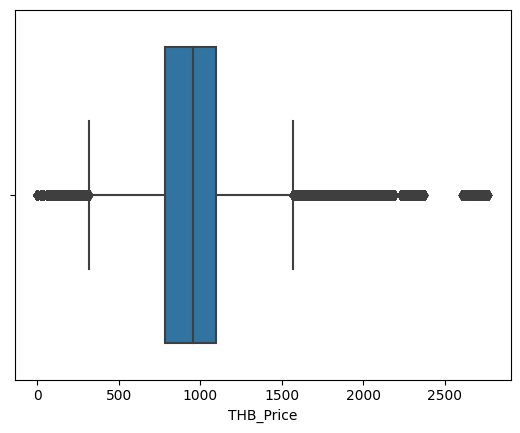

In [ ]:
sns.boxplot(x = df_pd['THB_Price'])

<Axes: xlabel='THB_Price', ylabel='Count'>

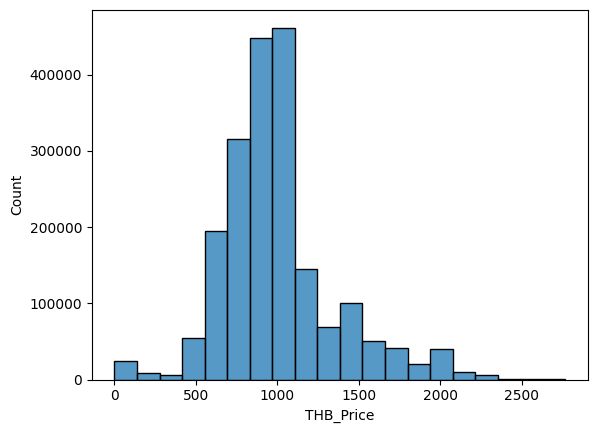

In [ ]:
# bins : the number of bar that you want to show

sns.histplot(df_pd['THB_Price'], bins=20)

In [ ]:
# Plotly - interactive chart ( Not recommend if your data is BIG )

# import plotly.express as px

# fig = px.scatter(df_pd, 'book_id', 'THB_Price')
# fig.show()

# DATA Cleaning

In [ ]:
# convert string to datetime

df = df.withColumn("timestamp",
                        F.to_timestamp(df.timestamp, 'yyyy-MM-dd HH:mm:ss')
                        )
df.dtypes

[('timestamp', 'timestamp'),
 ('user_id', 'string'),
 ('book_id', 'int'),
 ('rating', 'string'),
 ('country', 'string'),
 ('Price', 'double'),
 ('THB_Price', 'double')]

In [ ]:
# Try counting the transactions for the back-half of June.

df.where( (F.dayofmonth(df.timestamp) <= 15) & ( F.month(df.timestamp) == 6 ) ).count()

326077

In [ ]:
df.where(df['rating'] == 'Not rated yet').show()

+-------------------+--------+-------+-------------+--------------------+-----+------------------+
|          timestamp| user_id|book_id|       rating|             country|Price|         THB_Price|
+-------------------+--------+-------+-------------+--------------------+-----+------------------+
|2021-05-01 00:47:04|e9410570|    256|Not rated yet|United States of ...|30.79|          958.8006|
|2021-05-01 01:32:01|6cf1f6fd|   1127|Not rated yet|               Spain| 49.0|1525.8600000000001|
|2021-05-01 01:47:11|b109259f|   1144|Not rated yet|               Egypt| 28.0| 871.9200000000001|
|2021-05-01 02:19:21|dc4915a5|   1147|Not rated yet|United States of ...|27.99|          871.6086|
|2021-05-01 02:43:56|193b07dd|   1120|Not rated yet|           Argentina|28.34|          882.5076|
|2021-05-01 03:03:28|f7c6cd71|   1153|Not rated yet|          Montenegro| 24.5| 762.9300000000001|
|2021-05-01 03:22:33|310d0544|   1122|Not rated yet|              Canada|22.67|          705.9438|
|2021-05-0

In [ ]:
df.where(df['rating'] == 'Not rated yet').count()

3621

## Fill missing data

In [ ]:
diz = { "Not rated yet": '0', "4 out of 5 stars": '4', "4.5 out of 5 stars": '4.5', "5 out of 5 stars": '5' }

# diz = {k:str(v) for k,v in diz.items()}
# print(diz)

In [ ]:
df = df.replace(diz,1,"rating")
df = df.withColumn("rating_update", F.when(df['rating'].isNull(), '0').otherwise(df['rating']))

# Check the result

df.select('rating_update').distinct().show(n=100, truncate=False, vertical=False)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:2213: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


+-------------+
|rating_update|
+-------------+
|3.1          |
|4.2          |
|3            |
|4.4          |
|3.8          |
|2.7          |
|2.9          |
|4.5          |
|0            |
|2.5          |
|4.9          |
|3.4          |
|5            |
|3.3          |
|1.8          |
|4.3          |
|3.5          |
|4.8          |
|4.1          |
|4.6          |
|3.6          |
|1.5          |
|2.8          |
|3.2          |
|2.2          |
|1            |
|3.7          |
|4.7          |
|4            |
|2.3          |
|3.9          |
+-------------+



In [ ]:
# replace rating_update to rating

df = df.drop("rating").withColumnRenamed('rating_update', 'rating')

In [ ]:
df.dtypes

[('timestamp', 'timestamp'),
 ('user_id', 'string'),
 ('book_id', 'int'),
 ('country', 'string'),
 ('Price', 'double'),
 ('THB_Price', 'double'),
 ('rating', 'string')]

In [ ]:
# convert 'rating', 'string' to 'rating', 'double(float)'

df = df.withColumn("rating",df.rating.cast('double'))
df.dtypes

[('timestamp', 'timestamp'),
 ('user_id', 'string'),
 ('book_id', 'int'),
 ('country', 'string'),
 ('Price', 'double'),
 ('THB_Price', 'double'),
 ('rating', 'double')]

In [ ]:
# Check missing value

df.select([ F.sum(F.col(colname).isNull().cast("int")).alias(colname) for colname in df.columns ]).show()

+---------+-------+-------+-------+-----+---------+------+
|timestamp|user_id|book_id|country|Price|THB_Price|rating|
+---------+-------+-------+-------+-----+---------+------+
|        0|      0|      0|      0|    0|        0|     0|
+---------+-------+-------+-------+-----+---------+------+



# ANOMALY Detection


In [ ]:
df.where(df["user_id"].rlike("^[a-z0-9]{8}$")).count()

1998821

In [ ]:
anm = df.where(df["user_id"].rlike("^[a-z0-9]{8}$"))
df_anormal = df.subtract(anm)

df_anormal.show()

+---------+-------+-------+-------+-----+---------+------+
|timestamp|user_id|book_id|country|Price|THB_Price|rating|
+---------+-------+-------+-------+-----+---------+------+
+---------+-------+-------+-------+-----+---------+------+



## Finding outliers
- From the exploratory data analysis (EDA), we have observed outliers in the price data.

<Axes: xlabel='Price'>

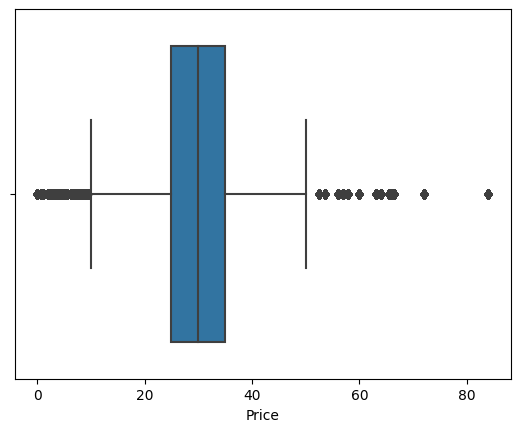

In [ ]:
sns.boxplot(x = df_pd['Price'])

In [ ]:
q = df_pd["Price"].quantile(0.99)

df.where( df.Price > q ).select("book_id").distinct().show()

+-------+
|book_id|
+-------+
|    737|
|    631|
|   1380|
|   1410|
|    646|
|   1831|
|    635|
+-------+



In this case, we checked the outlier by searching for *book_id: 635* (for example) from the [source](https://www.audible.com/pd/The-Power-Broker-Audiobook/B0051JH67K?ipRedirectOverride=true&overrideBaseCountry=true&pf_rd_p=2756bc30-e1e4-4174-bb22-bce00b971761&pf_rd_r=MF7KC1JQF3A6GK2ET8XM), and we confirmed that the data is correct. Therefore, we will take no action.

# Clean data with Spark SQL

In [ ]:
# Convert the Spark DataFrame to a TempView first.
# and then you can query by SQL command

df.createOrReplaceTempView("data")

df_sql = spark.sql("SELECT * FROM data")
df_sql.show()

+-------------------+--------+-------+--------------------+-----+------------------+------+
|          timestamp| user_id|book_id|             country|Price|         THB_Price|rating|
+-------------------+--------+-------+--------------------+-----+------------------+------+
|2021-05-01 00:00:01|ad8eca41|   1584|            Portugal| 35.0|            1089.9|   4.6|
|2021-05-01 00:00:03|561b26c1|    829|United States of ...|19.59|          610.0326|   4.8|
|2021-05-01 00:00:04|81f149e5|   1391|               Japan| 31.5|            980.91|   4.6|
|2021-05-01 00:00:07|4f218413|   1586|              Taiwan|19.95| 621.2429999999999|   4.8|
|2021-05-01 00:00:18|a4066781|    300|United States of ...|17.49|          544.6386|   4.8|
|2021-05-01 00:00:21|bbbd603a|   1377|United States of ...|34.99|         1089.5886|   4.6|
|2021-05-01 00:00:22|f636754b|    342|              Canada| 63.0|           1961.82|   4.8|
|2021-05-01 00:00:26|0eea4bbd|   1600|United States of ...|24.95|           776.

In [ ]:
df_sql_country = spark.sql(
    """
    SELECT distinct country
    FROM data
    ORDER BY country
    """
    )
df_sql_country.show(20)

+---------+
|  country|
+---------+
|  Algeria|
|Argentina|
|Australia|
|  Austria|
|  Bahamas|
|  Belgium|
|   Brazil|
|   Canada|
|    China|
| Colombia|
|  Croatia|
|  Denmark|
|    Dubai|
|    Egypt|
|  Estonia|
|  Finland|
|   France|
|  Germany|
|  Greece |
|  Hungary|
+---------+
only showing top 20 rows



In [ ]:
df_sql_country = spark.sql(
    """
    SELECT *
    FROM data
    WHERE user_id NOT RLIKE '^[a-z0-9]{8}$'
    """
    )
df_sql_country.show(20)

+---------+-------+-------+-------+-----+---------+------+
|timestamp|user_id|book_id|country|Price|THB_Price|rating|
+---------+-------+-------+-------+-----+---------+------+
+---------+-------+-------+-------+-----+---------+------+



# Export

In [ ]:
# This method will save in folder and have partition inside

df.write.csv('/content/drive/MyDrive/myColab_Notebooks/Cleaned_data.csv', header = True)

In [ ]:
# If you want to save in one file use this

df.coalesce(1).write.csv('Cleaned_Data_Single.csv', header = True)

- Results

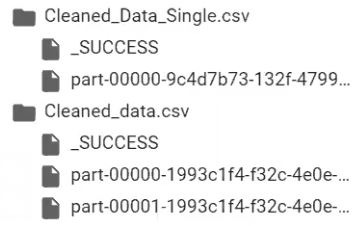

## How do I read them
when there are several files?

In [ ]:
readData = spark.read.csv('/content/drive/MyDrive/myColab_Notebooks/Cleaned_data.csv/part-*.csv', header = True, inferSchema = True)

In [ ]:
# check the row

readData.count()